# Challenge Description 

Company XYZ is an e-commerce site that sells hand-made clothes.
You have to build a model that predicts whether a user has a high probability of using the site to
perform some illegal activity or not. This is a super common task for data scientists.
You only have information about the user first transaction on the site and based on that you
have to make your classification ("fraud/no fraud").

### Our Goal

1. For each user, determine her country based on the numeric IP address.
2. Build a model to predict whether an activity is fraudulent or not. Explain how different
assumptions about the cost of false positives vs false negatives would impact the model.
3. Your boss is a bit worried about using a model she doesn't understand for something as
important as fraud detection. How would you explain her how the model is making the
predictions? Not from a mathematical perspective (she couldn't care less about that), but
from a user perspective. What kinds of users are more likely to be classified as at risk?
What are their characteristics?
4. Let's say you now have this model which can be used live to predict in real time if an
activity is fraudulent or not. From a product perspective, how would you use it? That is,
what kind of different user experiences would you build based on the model output?

In [1]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Data Cleaning

In [2]:
fraud_data = pd.read_csv('day4.csv',parse_dates = ['signup_time','purchase_time'])
ip_data = pd.read_csv('day4_2.csv')
# rename the first column
fraud_data.rename(columns = {fraud_data.columns[0]:'user_id'},inplace = True)

In [3]:
fraud_data.head(5)

user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0

In [4]:
ip_data.head(5)

lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0                16777727      China
2              16777728.0                16778239      China
3              16778240.0                16779263  Australia
4              16779264.0                16781311      China

In [5]:
fraud_data.shape[0]
ip_data.shape[0]

138846

In [6]:
%%time
def find_country(x):
    df = ip_data[(ip_data['lower_bound_ip_address']<= x) & (ip_data['upper_bound_ip_address']>= x)]
    if len(df) == 1:
        return df.country.values[0]
    else:
        return 'NA'

fraud_data['country'] = fraud_data['ip_address'].apply(find_country)

CPU times: user 3min 21s, sys: 1.44 s, total: 3min 22s
Wall time: 3min 23s


In [7]:
fraud_data.head(5)

user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class        country  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0          Japan  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  United States  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  United States  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0             NA  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  United States

In [8]:
fraud_data.describe()

user_id  purchase_value            age    ip_address  \
count  151112.000000   151112.000000  151112.000000  1.511120e+05   
mean   200171.040970       36.935372      33.140704  2.152145e+09   
std    115369.285024       18.322762       8.617733  1.248497e+09   
min         2.000000        9.000000      18.000000  5.209350e+04   
25%    100642.500000       22.000000      27.000000  1.085934e+09   
50%    199958.000000       35.000000      33.000000  2.154770e+09   
75%    300054.000000       49.000000      39.000000  3.243258e+09   
max    400000.000000      154.000000      76.000000  4.294850e+09   

               class  
count  151112.000000  
mean        0.093646  
std         0.291336  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

### EDA

In [9]:
# time
fraud_data['signup_year'] = fraud_data['signup_time'].apply(lambda x: x.year)
fraud_data['signup_month'] = fraud_data['signup_time'].apply(lambda x: x.month)
fraud_data['signup_day'] = fraud_data['signup_time'].apply(lambda x: x.day)
fraud_data['signup_hour'] = fraud_data['signup_time'].apply(lambda x: x.hour)

fraud_data['purchase_year'] = fraud_data['purchase_time'].apply(lambda x: x.year)
fraud_data['purchase_month'] = fraud_data['purchase_time'].apply(lambda x: x.month)
fraud_data['purchase_day'] = fraud_data['purchase_time'].apply(lambda x: x.day)
fraud_data['purchase_hour'] = fraud_data['purchase_time'].apply(lambda x: x.hour)

# add a new feature: time duration
fraud_data['duration'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.days

In [10]:
fraud_data.head(5)

user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  ...        country  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08  ...          Japan   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08  ...  United States   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09  ...  United States   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09  ...             NA   
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08  ...  United States   

  signup_year  signup_month  signup_day  signup_hour  purchase_year  \
0        2015             2          24           22           2015   
1        2015             6           7           20           2015   
2        2015             1           1           18           2015   
3        2015             4          28           21           2015   
4        2015             7          21            7           2015   

   purchase_month  purchase_day  purchase_hour  duration  
0               4            18              2        52  
1               6             8              1         0  
2               1             1             18         0  
3               5             4             13         5  
4               9             9             18        50  

[5 rows x 21 columns]

In [22]:
fraud = fraud_data[fraud_data['class'] == 1]

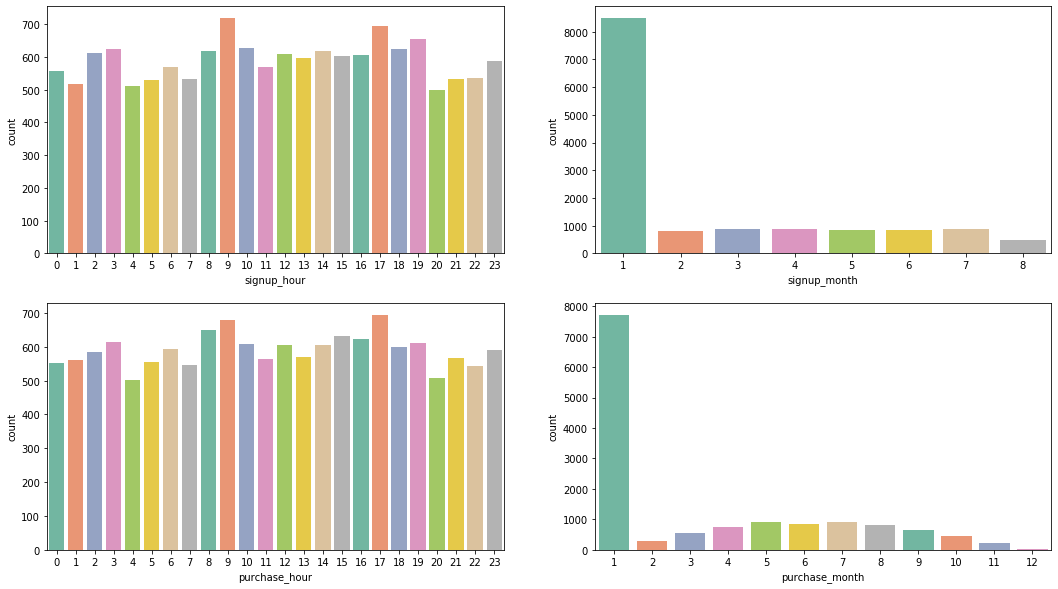

In [29]:
# time analysis
fig, ax = plt.subplots(2,2,figsize = (18,10))

sns.countplot(x = 'signup_hour', data = fraud , ax = ax[0,0],palette = 'Set2')
sns.countplot(x = 'signup_month', data = fraud , ax = ax[0,1],palette = 'Set2')
sns.countplot(x = 'purchase_hour', data = fraud , ax = ax[1,0],palette = 'Set2')
sns.countplot(x = 'purchase_month', data = fraud , ax = ax[1,1],palette = 'Set2')

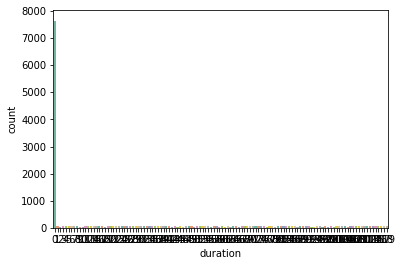

In [31]:
sns.countplot(x = 'duration', data = fraud ,palette = 'Set2')

In [ ]:
# spatial analysis

In [ ]:
# other categorical features analysis

In [ ]:
# other continuous features analysis

#### Based on above analysis, we can find that fraud activities usually happen at time between , 



#### Besides, 

### Modelling for Prediction

#### Here we will be using Random forest to predict the binary value.

In [ ]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init()
h2o.remove_all()

In [ ]:
h2o_df  = H2OFrame(fraud_data)
h2o_df ['class'] = h2o_df ['class'].asfactor()
h2o_df.summary()

In [ ]:
fraud_data.columns

In [ ]:
feature = ['purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age','duration']
target = 'class'
# split train and test set 
strat_split = h2o_df['class'].stratified_split(test_frac = 0.3,seed = 42)
train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance,palette = 'Set2')
plt.show()

#### Evaluate the result

In [ ]:
h2o.predict(model,test[feature])
